In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
articles_df = pd.read_csv('shared_articles.csv')
articles_df = articles_df[articles_df['eventType'] == 'CONTENT SHARED']

In [3]:
interactions_df = pd.read_csv('users_interactions.csv')

In [4]:
interactions_df.personId = interactions_df.personId.astype(str)
interactions_df.contentId = interactions_df.contentId.astype(str)
articles_df.contentId = articles_df.contentId.astype(str)

In [5]:
event_type_strength = {
   'VIEW': 1.0,
   'LIKE': 2.0, 
   'BOOKMARK': 2.5, 
   'FOLLOW': 3.0,
   'COMMENT CREATED': 4.0,  
}

In [6]:
interactions_df['eventStrength'] = interactions_df.eventType.apply(lambda x: event_type_strength[x])

In [7]:
users_interactions_count_df = (
    interactions_df
    .groupby(['personId', 'contentId'])
    .first()
    .reset_index()
    .groupby('personId').size())

users_with_enough_interactions_df = \
    users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['personId']]

In [8]:
users_with_enough_interactions_df[:2]

,personId
0,-1007001694607905623
1,-1032019229384696495


In [9]:
interactions_from_selected_users_df = interactions_df.loc[np.in1d(interactions_df.personId,
            users_with_enough_interactions_df)]

In [10]:
interactions_from_selected_users_df[:2]

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry,eventStrength
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN,1.0
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US,1.0


In [11]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = (
    interactions_from_selected_users_df
    .groupby(['personId', 'contentId']).eventStrength.sum()
    .apply(smooth_user_preference)
    .reset_index().set_index(['personId', 'contentId'])
)
interactions_full_df['last_timestamp'] = (
    interactions_from_selected_users_df
    .groupby(['personId', 'contentId'])['timestamp'].last()
)
        
interactions_full_df = interactions_full_df.reset_index()

In [12]:
interactions_full_df[:2]

,personId,contentId,eventStrength,last_timestamp
0,-1007001694607905623,-5065077552540450930,1.0,1470395911
1,-1007001694607905623,-6623581327558800021,1.0,1487240080


In [13]:
from sklearn.model_selection import train_test_split

split_ts = 1475519545
interactions_train_df = interactions_full_df.loc[interactions_full_df.last_timestamp < split_ts].copy()
interactions_test_df = interactions_full_df.loc[interactions_full_df.last_timestamp >= split_ts].copy()


Так как теперь вам известны более сложные алгоритмы построения рекомендательных систем, начнём с них.

Для начала необходимо построить матрицу, в которой по столбцам будут находиться id статей, по строкам — id пользователей, а на пересечениях строк и столбцов — оценка взаимодействия пользователя со статьёй. Если взаимодействия не было, в соответствующей ячейке должен стоять ноль.

Найдите оценку взаимодействия пользователя с ID -1032019229384696495 со статьёй с ID 943818026930898372. Результат округлите до двух знаков после точки-разделителя.

Примечание. Здесь и далее (пока не будет указано иное) необходимо работать с обучающей выборкой.

In [58]:
ratings = pd.pivot_table(
    interactions_train_df,
    values='eventStrength',
    index='personId',
    columns='contentId').fillna(0)
ratings.loc['-1032019229384696495','943818026930898372']

2.321928094887362

In [15]:
ratings[:2]

contentId,-1006791494035379303,-1021685224930603833,-1022885988494278200,-1024046541613287684,-1033806831489252007,-1038011342017850,-1039912738963181810,-1046621686880462790,-1051830303851697653,-1055630159212837930,...,9217155070834564627,921770761777842242,9220445660318725468,9222265156747237864,943818026930898372,957332268361319692,966067567430037498,972258375127367383,980458131533897249,98528655405030624
personId,,,,,,,,,,,,,,,,,,,,,
-1007001694607905623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
-1032019229384696495,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,2.321928,0.0,0.0,0.0,0.0,0.0


Теперь давайте попробуем применить memory-based-подход коллаборативной фильтрации.

Примечание. Данных достаточно много, поэтому для увеличения скорости работы преобразуйте таблицу в массив numpy.

Задание 6.2
1 point possible (graded)
Найдите среднее арифметическое всех чисел в получившемся массиве. Результат округлите до трёх знаков после точки-разделителя.

In [16]:
ratings_m = ratings.values
ratings_m.mean()

0.016673743043640697

Перейдём к реализации коллаборативной фильтрации. Ранее мы делали это с помощью библиотеки surprise, однако это не всегда удобно, так как эта библиотека имеет ограниченное количество метрик для оценки качества и небольшой потенциал для более тонкой настройки алгоритма. Поэтому давайте попробуем реализовать алгоритмы коллаборативной фильтрации с нуля. Такая практика применяется, если необходимо выстроить более сложную систему, чем могут предложить готовые модули. Кроме того, «ручная» реализация алгоритмов позволит лучше понять принцип их работы.

Постройте матрицу схожести. Для этого вычислите все попарные коэффициенты корреляции для матрицы, полученной в предыдущем задании. Для каждой пары учитывайте только ненулевые значения (так как нулевые обозначают отсутствие взаимодействия и не интересуют нас). Выведите результат, полученный в ячейке с третьим индексом по строкам и сороковым — по столбцам.

In [17]:
similarity_users = np.zeros((len(ratings_m), len(ratings_m)))
for i in (range(len(ratings_m)-1)):
    for j in range(i+1, len(ratings_m)):
     
        mask_uv = (ratings_m[i] != 0) & (ratings_m[j] != 0)
        ratings_v = ratings_m[i, mask_uv]
        ratings_u = ratings_m[j, mask_uv]

        similarity_users[i,j] = np.corrcoef(ratings_v, ratings_u)[0, 1]
        similarity_users[j,i] = similarity_users[i,j]
    
similarity_users[3,40]

/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invali

-0.3333333333333333

Теперь у нас есть матрицы схожести пользователей. Их можно использовать для построения рекомендаций. Чтобы это сделать, надо реализовать следующий алгоритм.

Для каждого пользователя:

1) найти пользователей с похожестью больше 0;

2) для каждой статьи вычислить долю пользователей (среди выделенных на первом шаге), которые взаимодействовали со статьёй;

3) порекомендовать статьи с наибольшими долями со второго шага (среди тех, которые пользователь ещё не видел).

Постройте рекомендательную систему по алгоритму, описанному выше. Найдите первую рекомендацию для строки 34 (если считать с нуля).

In [18]:
interactions = (
    interactions_train_df
    .groupby('personId')['contentId'].agg(lambda x: list(x))
    .reset_index()
    .rename(columns={'contentId': 'true_train'})
    .set_index('personId')
)
 
interactions['true_test'] = (
    interactions_test_df
    .groupby('personId')['contentId'].agg(lambda x: list(x))
)
 
interactions['true_test'] = [ [] if x is np.NaN else x for x in interactions['true_test'] ]

prediction_user_based = []
for i in range(len(similarity_users)):
    users_sim = similarity_users[i] > 0
    if len(users_sim) == 0:
        prediction_user_based.append([])
    else:
        tmp_recommend = np.argsort(ratings_m[users_sim].sum(axis=0))[::-1]
        tmp_recommend = ratings.columns[tmp_recommend]
        recommend = np.array(tmp_recommend)[~np.in1d(tmp_recommend, interactions.iloc[i])][:10]
        prediction_user_based.append(list(recommend))
interactions['prediction_user_based'] = prediction_user_based
prediction_user_based[34][0]

'98528655405030624'

In [22]:
similarity_users.shape

(1112, 1112)

In [24]:
similarity_users[0]

array([ 0., nan, nan, ..., nan, nan, nan])

In [25]:
np.argsort(ratings_m[users_sim].sum(axis=0))[::-1]

array([2365,  776,  792, ..., 1574, 1573,    0])

In [29]:
ratings.columns[np.argsort(ratings_m[users_sim].sum(axis=0))[::-1]]

Index(['98528655405030624', '-6603351162010419903', '-6707474286910397949',
       '-6704596170548214779', '-6697357763177451167', '-668191656681035303',
       '-667193404227875686', '-6661204361884000663', '-6654470039478316910',
       '-6651333707067617642',
       ...
       '3779639438468810958', '3761187656635209729', '3727587882617538492',
       '3756874058845999993', '3751305746867503759', '374674704202038318',
       '3746463631389880443', '374352050712569304', '3742318026370211556',
       '-1006791494035379303'],
      dtype='object', name='contentId', length=2366)

После того как сделаны предсказания, можно вычислить качество по метрике, которую мы определили в предыдущем модуле при решении этой задачи:

In [32]:
def calc_precision(column):
    return ( interactions.apply(  lambda row:len(set(row['true_test']).intersection(
                set(row[column]))) /min(len(row['true_test']) + 0.001, 10.0), axis=1)).mean()

Вычислите точность полученного предсказания. Ответ округлите до трёх знаков после точки-разделителя.

In [33]:
calc_precision('prediction_user_based')

0.003541692918885616

Теперь реализуем рекомендательную систему с использованием SVD.

Разложите матрицу взаимодействий пользователей со статьями с помощью функции svd из модуля scipy. Найдите максимальное значение в получившейся матрице U. Результат округлите до двух знаков после точки-разделителя.

In [35]:
from scipy.linalg import svd

In [36]:
U, sigma, V = svd(ratings)
U.max()

0.7071067811865459

Значения матрицы с сингулярными числами отсортированы по убыванию. Допустим, мы хотим оставить только первые 100 компонентов и получить скрытые представления размерности 100. Для этого необходимо оставить 100 столбцов в матрице U, только первые 100 значений из sigma (и сделать из них диагональную матрицу) и 100 столбцов в матрице V. Затем необходимо перемножить преобразованные матрицы.


Найдите сумму всех элементов в новой сингулярной матрице. Ответ округлите до двух знаков после точки-разделителя.

In [38]:
k = 100
s = np.diag(sigma[:k])
U = U[:, 0:k]
V = V[0:k, :]
s.sum()

2096.527500820686

Теперь мы можем сделать предсказание по полученной матрице.

Примечание. Помните, что не нужно учитывать статьи, которые уже были просмотрены пользователем.

Найдите для каждого пользователя статьи с наибольшими оценками в восстановленной матрице.

Вычислите качество полученного предсказания, используя всё ту же метрику точности. Ответ округлите до трёх знаков после точки-разделителя.

In [44]:
new_ratings = U.dot(s).dot(V)
new_ratings = pd.DataFrame(new_ratings, index=ratings.index, columns=ratings.columns)
top_k = 10
predictions = []
for personId in interactions.index:
    prediction = (
        new_ratings
        .loc[personId]
        .sort_values(ascending=False)
        .index.values
    )
    
    predictions.append(
        list(prediction[~np.in1d(
            prediction,
            interactions.loc[personId, 'true_train'])])[:top_k])
interactions['prediction_svd'] = predictions

calc_precision('prediction_svd')

0.012212989310270756

Итак, мы реализовали два алгоритма коллаборативной фильтрации буквально с нуля! Теперь для полноты картины давайте реализуем на этих данных гибридную модель и посмотрим, какое качество получится. Для этого воспользуемся уже изученной библиотекой LightFM.

Возьмите матрицу, подготовленную в задании 6.1. Разделите данные на валидационную и обучающую выборки в соотношении 3:10. В качестве значения параметра random_state возьмите число 13.

Обучите модель со 100 компонентами, параметром random_state = 13, темпом обучения 0.05 и функцией потерь 'warp'.

Вычислите показатель точности (precision). Ответ округлите до двух знаков после точки-разделителя.

In [48]:
!pip install lightfm
from lightfm.evaluation import precision_at_k

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.1/310.1 KB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.16-cp39-cp39-linux_x86_64.whl size=895288 sha256=ccb3bc9bae5c7db604cf1dbf9ed2948f1348020d7c4d05a8adbf2f6b180b6a39
  Stored in directory: /root/.cache/pip/wheels/d7/75/52/e42e5f9cd86d4902a352aff4dadde75ec041af713ffcf3ed05
Successfully built lightfm


In [52]:
from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split

In [59]:
model = LightFM(loss='warp', #определяем функцию потерь
                random_state=13, #фиксируем случайное разбиение
                learning_rate=0.05, #темп обучения
                no_components=100) 

In [62]:
from scipy.sparse import csr_matrix

In [65]:
ratings_=csr_matrix(ratings)

In [66]:
train,test = random_train_test_split(ratings_, test_percentage=0.3, random_state=13)

In [68]:
model = model.fit(train)

In [69]:
prec_score = precision_at_k(model, test).mean()
print(prec_score)

0.03764706


Вы закончили изучение рекомендательных систем, поздравляем!

В этом модуле вы:

разобрались с принципом работы всех основных моделей рекомендательных систем;

научились реализовывать их на практике;

смогли построить рекомендательную систему, использовав различные подходы.

Выполните несколько заданий, чтобы закрепить пройденный материа

В магазине три покупателя и три товара. Ниже приведены полученные векторы признаков для каждого пользователя и продукта. Основываясь на этих данных, выберите, какой продукт вы бы с наибольшей вероятностью рекомендовали пользователю № 2.

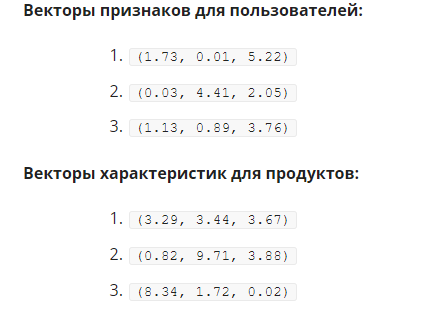

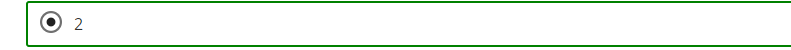

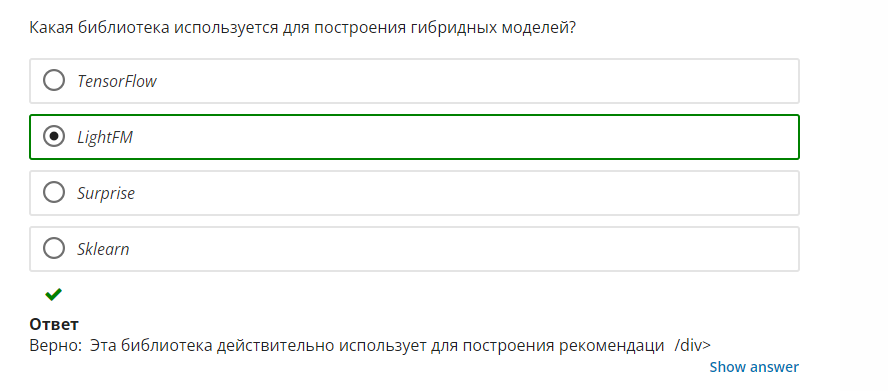

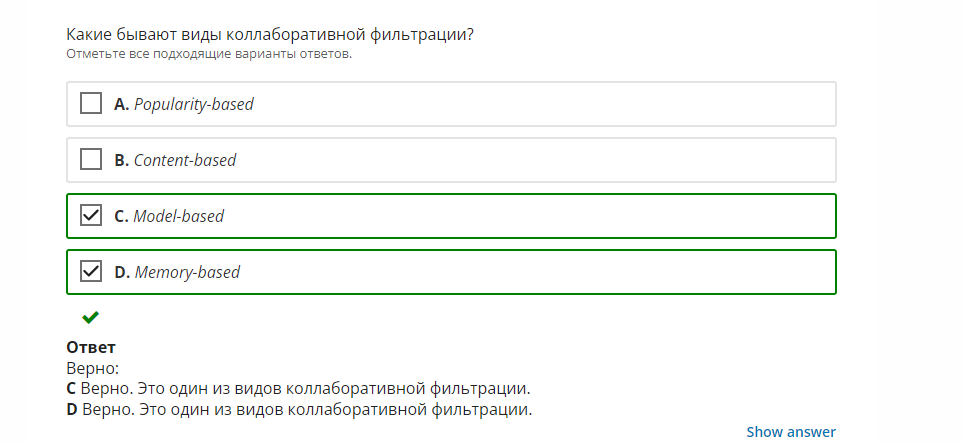

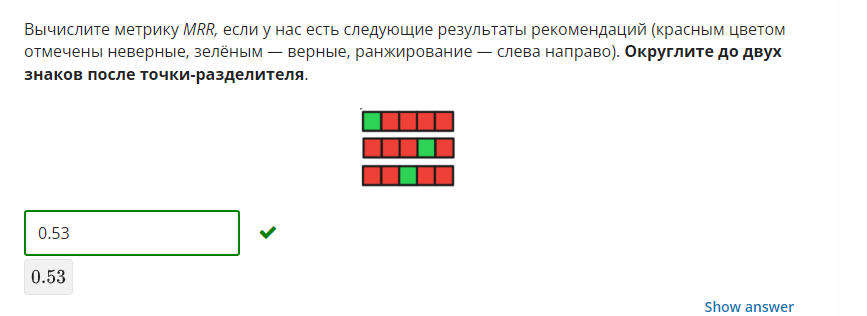

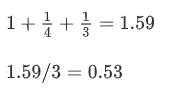

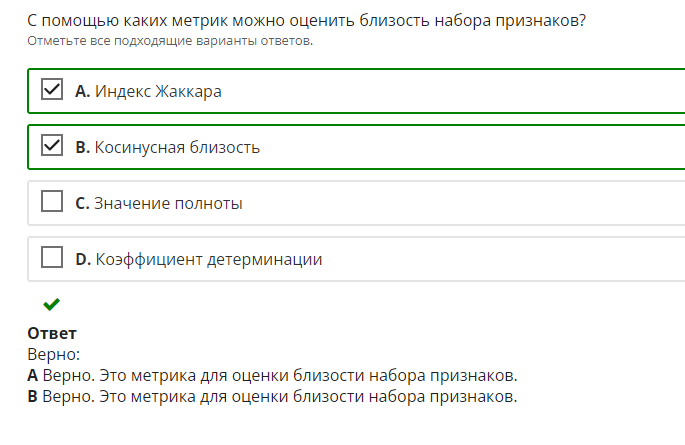

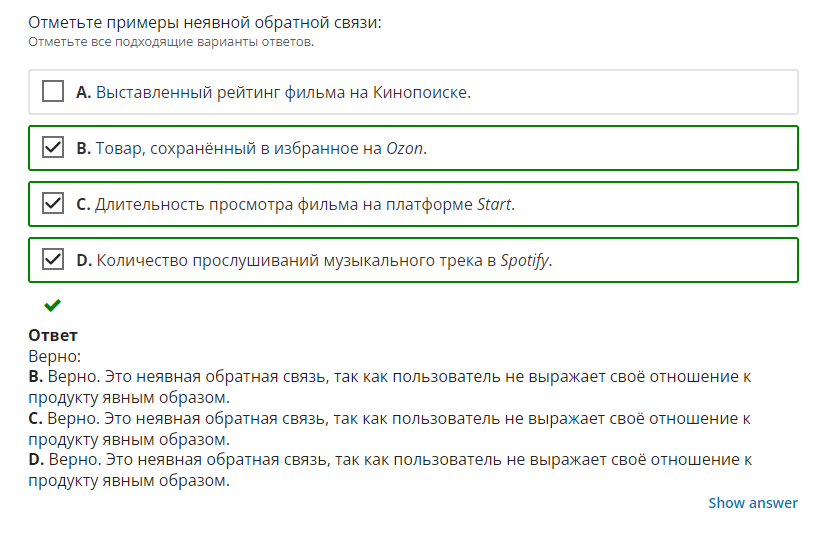

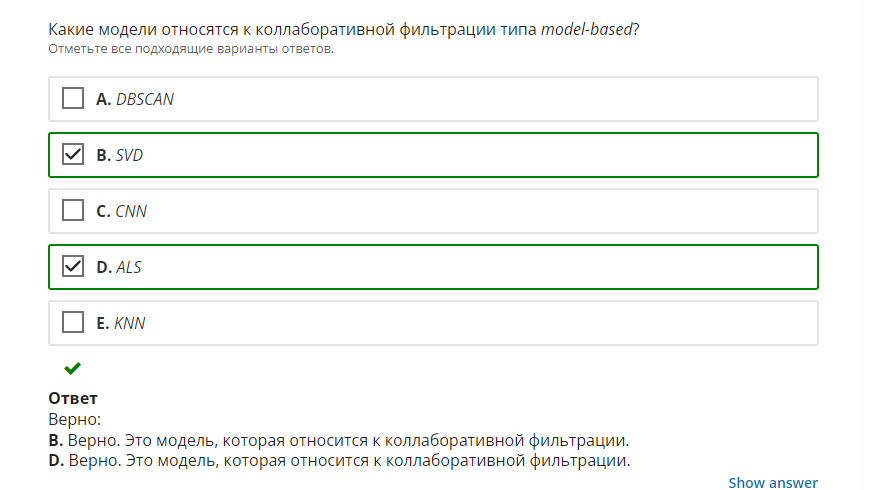

https://medium.com/analytics-vidhya/7-types-of-hybrid-recommendation-system-3e4f78266ad8

https://arxiv.org/pdf/1707.07435.pdf